In [ ]:
#!pip install tensorflow
#!pip install sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import copy
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss #used as a metric, not involved in training/calculations
#one-hot encoding
import warnings
warnings.filterwarnings('ignore')

# Load data

In [ ]:
(train_x, train_y),(test_x, test_y) = keras.datasets.fashion_mnist.load_data()

train_x = np.array(train_x, dtype = 'float')
test_x = np.array(test_x, dtype = 'float')

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

## Data augmentation

In [ ]:
from scipy.ndimage import rotate

In [ ]:
def data_aug(n, angle=45):
  #n - number of extra instances
  #angle - angle by which the image will be rotated (in degrees)
  #outputs "raw" image data

  inds = np.random.RandomState(1234).permutation(train_x.shape[0])[:n]
  return rotate(train_x[inds], angle, axes=(2,1), reshape=False), train_y[inds]

In [ ]:
extrax,extray = data_aug(20000,60)

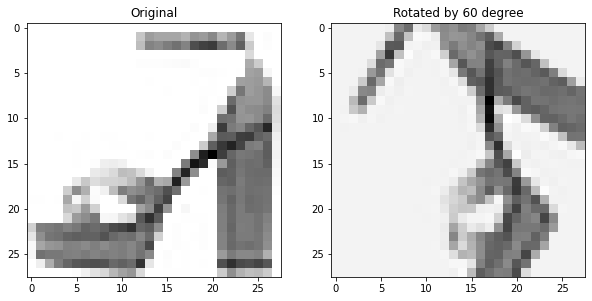

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(train_x[30329],cmap='Greys')
ax[0].set_title("Original")

ax[1].imshow(extrax[0],cmap='Greys')
ax[1].set_title("Rotated by 60 degree")

#plt.savefig('rotatecompare.png',bbox_inches='tight')
plt.show()

## Normalization

In [ ]:
def dataprocess(x):

  raw = np.reshape(x, (x.shape[0], 784))

  non = raw[...,np.newaxis]

  nor = non-np.mean(non, axis = 1)[:,None]
  nor = nor/np.std(non, axis = 1)[:,None]

  return raw, np.reshape(nor, (x.shape[0], 784)), np.reshape(nor, (x.shape[0], 28, 28))

In [ ]:
train_x_raw, train_x_nor, train_x_2D = dataprocess(train_x)
test_x_raw, test_x_nor, test_x_2D = dataprocess(test_x)

In [ ]:
nor_image = np.reshape(train_x_nor[30329],(28,28))

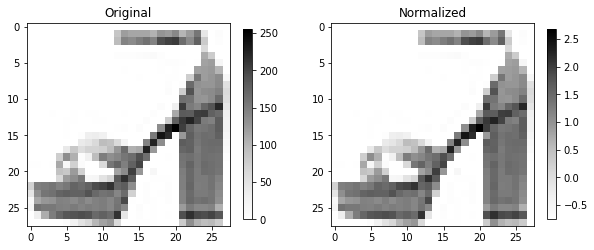

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

pos1 = ax[1].imshow(nor_image,cmap='Greys')
fig.colorbar(pos1, ax=ax[1],shrink=0.7)
ax[1].set_title("Normalized")

pos2 = ax[0].imshow(train_x[30329],cmap='Greys')
fig.colorbar(pos2, ax=ax[0],shrink=0.7)
ax[0].set_title("Original")

plt.savefig('normcompare.png',bbox_inches='tight')
plt.show()

### Stacking augmented data to original

In [ ]:
extra_x_raw, extra_x_nor, extra_x_2D = dataprocess(extrax)

In [ ]:
extrain_x_nor = np.vstack((train_x_nor,extra_x_nor))
extrain_x_2D = np.vstack((train_x_2D,extra_x_2D))
extrain_y = np.vstack((train_y,extray))

In [ ]:
nor_rot = np.reshape(extra_x_nor[0],(28,28))

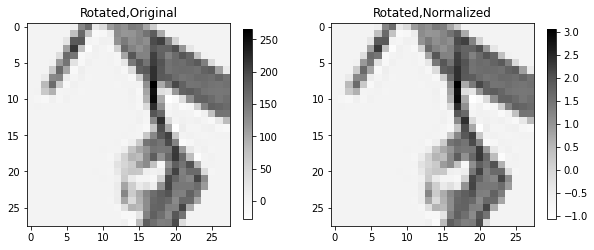

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

pos1 = ax[1].imshow(nor_rot,cmap='Greys')
fig.colorbar(pos1, ax=ax[1],shrink=0.7)
ax[1].set_title("Rotated,Normalized")

pos2 = ax[0].imshow(extrax[0],cmap='Greys')
fig.colorbar(pos2, ax=ax[0],shrink=0.7)
ax[0].set_title("Rotated,Original")

plt.savefig('rotnormcompare.png',bbox_inches='tight')
plt.show()

# MLP

### Useful functions

In [ ]:
ReLU = lambda x: np.maximum(0,x)
ReLUp = lambda x: 1*(x>0)
#derivative of ReLu activation (ReLU')

logistic = lambda x: 1/(1+np.exp(-x))
tanh = lambda x: 2*logistic(x)-1
# tanhp = lambda x: 1-tanh(x)**2
tanhp = lambda y: 1-y**2

#fix gamma=.1 in leakyReLU
leakyReLU = lambda x: np.maximum(0,x) + 0.01*np.minimum(0,x)
leakyReLUp = lambda x: 1*(x>0) + 0.01*(x<=0)

weight = lambda D,M: np.random.randn(D,M)*.01
#D: number of units in the previous layer (can be input features)
#M: number of units in the next layer
#*.01 copied from code review example

bias = lambda D: np.random.randn(D)

softmax = lambda x: np.exp(x)/np.sum(np.exp(x),axis=1)[:,None]

def evaluate_acc(y_true, y_pred):
  correct = np.equal(y_true,y_pred)
  
  acc = np.sum(correct)/len(y_true)

  return (acc)

### MLP class

Structure with two hidden layers: $x\; -- \; (q_1=W_1x+b_1) \; \rightarrow [z_1=ReLU(q_1)]\; -- \; (q_2=W_2z_1+b_2) \; \rightarrow [z_2=ReLU(q_2)] \; -- \; (q_3=W_3z_2+b_3) \; \rightarrow \hat{y} = softmax(q_3)$

$J = \Sigma_n L(y^{(n)},softmax(W_3\:ReLU(W_2\:ReLU(W_1x+b_1)+b_2)+b_3))$

In [ ]:
class MLP:
  class Layer:
    def __init__(self, W, b, activation, df, beta_1, beta_2, p):
      """
      df: activation function derivative w.r.t. Y
      """
      self.W = W # D,M (M is number of unit in next layer)
      self.b = b # D,
      self.activation = activation
      self.df = df
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.moment_1_W = np.zeros(W.shape)
      self.moment_1_b = np.zeros(b.shape)
      self.moment_2_W = np.zeros(W.shape)
      self.moment_2_b = np.zeros(b.shape)
      self.t = 0
      self.p = p
    
    def forward(self, X, train=True):
      """
      param:
        X: z_i-1 == forward output of previous layer == input of current layer
      
      return:
        Y: z_i = activation(W_i * z_i-1 + b_i)
      """
      self.X = X # N,D
      self.Y = self.activation(np.dot(X, self.W) + self.b) # N,D * D,M = N,M
      self.drop = np.ones(self.Y.shape)
      if self.Y.shape[1] != 10 and train: #final layer no dropout
        self.drop = np.random.binomial(1, self.p, size=self.Y.shape) / self.p
      self.Y *= self.drop
      return self.Y

    def backward(self, dy):
      """
      param:
        dy: backproped gradient of next layer
      
      return:
        dX: backprop to previous layer
        dW: gradient w.r.t. weights
        db: gradient w.r.t. biases
      """
      if self.df is None: # softmax, use dy directly
        prev_grad = dy
      else:
        # previous gradient * derivative of activation function
        prev_grad = dy * self.df(self.Y) # element-wise -> N,M
      dX = np.dot(prev_grad, self.W.T) # N,M  M,D -> N,D  
      dW = np.dot(self.X.T, prev_grad)
      db = prev_grad.sum(axis=0)
      # momentum
      self.moment_1_W = self.beta_1 * self.moment_1_W + (1-self.beta_1) * dW
      self.moment_1_b = self.beta_1 * self.moment_1_b + (1-self.beta_1) * db
      # rmsprop
      self.moment_2_W = self.beta_2 * self.moment_2_W + (1-self.beta_2) * np.square(dW)
      self.moment_2_b = self.beta_2 * self.moment_2_b + (1-self.beta_2) * np.square(db)
      self.t += 1
      return dX, self.moment_1_W/(1-self.beta_1**self.t), self.moment_1_b/(1-self.beta_1**self.t), self.moment_2_W/(1-self.beta_2**self.t), self.moment_2_b/(1-self.beta_2**self.t)



  def __init__(self, ac_func = ReLU, ac_func_p=ReLUp, n_layers = 2, n_units = 128,
               learning_rate = .001, epoch = 10, batch_size = 200, 
               beta_1 = .9, beta_2=.999, epsilon = 1e-4, p = 0.5, random_state = None):
    self.n_layers = n_layers # number of hidden layers
    self.ac_func = ac_func
    self.ac_func_p = ac_func_p
    self.n_units = n_units
    self.learning_rate = learning_rate
    self.epoch = epoch
    self.batch_size = batch_size
    self.epsilon = epsilon
    self.rand = random_state if random_state else np.random.RandomState()
    self.layers = []
    self.training_loss = []
    self.beta_1 = beta_1 #for Adam
    self.beta_2 = beta_2
    self.p = p #dropout probability
            
  def fit(self, x, y):
    np.random.seed(1234)
    #weight = lambda D,M: self.rand.randn(D,M)*.01
    #D: number of units in the previous layer (can be input features)
    #M: number of units in the next layer
    #*.01 copied from code review example

    #bias = lambda D: self.rand.randn(D)
    
    N,D = x.shape
    structure = [D] + [self.n_units]*self.n_layers + [10]
    #e.g. [784,128,128,10]

    # hidden layers
    for i in range(self.n_layers):
      self.layers.append(self.Layer(weight(structure[i],structure[i+1]), bias(structure[i+1]), self.ac_func, self.ac_func_p, self.beta_1, self.beta_2, self.p))

    # output layer
    self.layers.append(self.Layer(weight(structure[self.n_layers],structure[self.n_layers+1]), bias(structure[self.n_layers+1]), softmax, None, self.beta_1, self.beta_2, self.p))
    # return self
    self.SGD(x,y)
    return self
    
  def predict(self, x):
    for layer in self.layers:
      y = layer.forward(x, train=False)
      x = y
    return np.argmax(y,axis=1)

  def SGD(self, x, y): # mini-batch SGD with adam
    learning_rate = self.learning_rate
    epoch = self.epoch
    batch_size = self.batch_size

    N = x.shape[0]
    norms = np.array([np.inf])

    for t in tqdm(range(self.epoch)):
    #for t in range(self.epoch):
      #inds = self.rand.permutation(N)
      inds = np.random.RandomState(t).permutation(N)
            
      for i in range(N//batch_size-1):
        if not np.any(norms > self.epsilon):
          print("early convergence")
          return

        batch_inds = inds[i*batch_size:min((i+1)*batch_size,len(inds))]
        xb = x[batch_inds]
        yb = y[batch_inds]
        
        yh = xb
        for layer in self.layers:
          yh = layer.forward(yh)
        
        # multi-class cross-entropy loss
        self.training_loss.append(log_loss(yb,yh))
        


        dy = yh-yb
        grad = []
        for j in range(len(self.layers)-1, -1, -1):
          layer = self.layers[j]
          dy, dW, db, sW, sb = layer.backward(dy)
          if j > 0:
            dy *= self.layers[j-1].drop
          grad.append(dW)
          grad.append(db)
          # update W and b
          layer.W = layer.W  - (learning_rate/np.sqrt(sW+self.epsilon)) * dW
          layer.b = layer.b  - (learning_rate/np.sqrt(sb+self.epsilon)) * db
        
        norms = np.array([np.linalg.norm(g) for g in grad])
        #if i == 0:
        #  print('i=0')
        #  print(self.layers[0].W[0])

## Testing

In [ ]:
#(potentially) optimal MLP
mlp = MLP(n_layers = 2,n_units = 256,ac_func = ReLU, ac_func_p = ReLUp,epoch=25,batch_size=200,p=.7)
results = mlp.fit(train_x_nor,extrain_y).predict(test_x_nor)
train_results = mlp.predict(train_x_nor)

100%|██████████| 25/25 [03:47<00:00,  9.11s/it]


0.10084191295744532
0.8959
0.9430666666666667


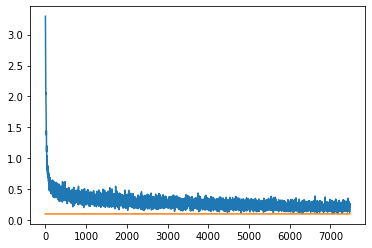

In [ ]:
#p=1
x = range(len(mlp.training_loss))
plt.plot(x, mlp.training_loss)
plt.plot(x, [min(mlp.training_loss)] * len(x))
print(min(mlp.training_loss))
print(evaluate_acc(np.argmax(test_y,axis=1), results))
print(evaluate_acc(np.argmax(train_y,axis=1), train_results))
plt.show()

In [ ]:
#three layers
mlp = MLP(n_layers = 3,n_units = 128,ac_func = ReLU, ac_func_p = ReLUp,epoch=25,batch_size=200,p=1)
results = mlp.fit(train_x_nor,extrain_y).predict(test_x_nor)
train_results = mlp.predict(train_x_nor)

100%|██████████| 25/25 [02:16<00:00,  5.45s/it]


0.06954038953014241
0.8819
0.94855


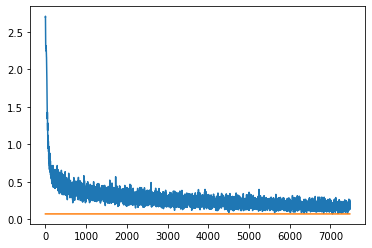

In [ ]:
#p=1
x = range(len(mlp.training_loss))
plt.plot(x, mlp.training_loss)
plt.plot(x, [min(mlp.training_loss)] * len(x))
print(min(mlp.training_loss))
print(evaluate_acc(np.argmax(test_y,axis=1), results))
print(evaluate_acc(np.argmax(train_y,axis=1), train_results))
plt.show()

epoch 12, batch size 100: train=0.92, test=0.87

epoch 25, batch size 100: train=0.95, test=0.88

epoch 25, batch size 600: train=0.93, test=0.88

epoch 75, batch size 600: train=0.98, test=0.88 (overfits)

## Test accuracy vs. dropout proportion

### Full training set

In [ ]:
epochs = [20,25,30,35,40]
p5 = []
p5train = []
p7 = []
p7train = []
p1 = []
p1train = []

for e in tqdm(epochs):
  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=.5)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  p5.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p5train.append(evaluate_acc(np.argmax(train_y,axis=1), mlp.predict(train_x_nor)))

  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=.7)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  p7.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p7train.append(evaluate_acc(np.argmax(train_y,axis=1), mlp.predict(train_x_nor)))

  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=1)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  p1.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p1train.append(evaluate_acc(np.argmax(train_y,axis=1), mlp.predict(train_x_nor)))

100%|██████████| 5/5 [32:03<00:00, 384.78s/it]


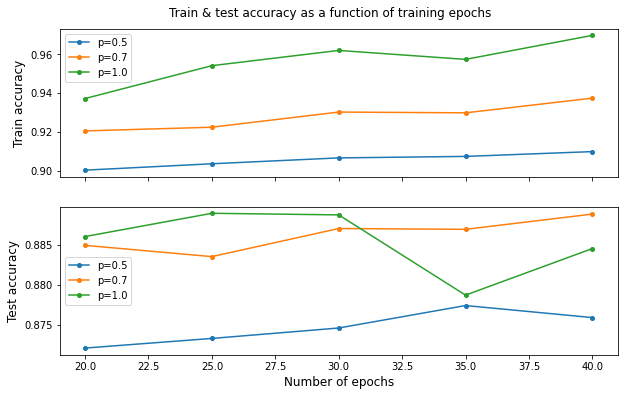

In [ ]:
x = epochs
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,6))

plt.suptitle('Train & test accuracy as a function of training epochs',x=.5,y=.93,fontsize=12)

ax[0].plot(x, p5train,'.-', markersize=8,label='p=0.5')
ax[0].plot(x, p7train,'.-', markersize=8,label='p=0.7')
ax[0].plot(x, p1train,'.-', markersize=8,label='p=1.0')
#ax[0].plot(x, [max(train_acc)] * len(x),label='Max. accuracy:'+str(round(max(train_acc),4)))
ax[1].plot(x, p5,'.-', markersize=8, label='p=0.5')
ax[1].plot(x, p7,'.-', markersize=8, label='p=0.7')
ax[1].plot(x, p1,'.-', markersize=8, label='p=1.0')
#ax[1].plot(x, [max(test_acc)] * len(x),label='Max. accuracy:'+str(round(max(test_acc),4)))

ax[1].set_xlabel('Number of epochs',fontsize=12)
ax[0].set_ylabel('Train accuracy',fontsize=12)
ax[1].set_ylabel('Test accuracy',fontsize=12)

ax[0].legend()
ax[1].legend()

plt.savefig('dropout.png',bbox_inches='tight')
plt.show()

### 3000 training instances

In [ ]:
epochs = [20,25,30,35,40]
p5 = []
p5train = []
p7 = []
p7train = []
p1 = []
p1train = []

size = 3000

for e in tqdm(epochs):
  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=.5)
  results = mlp.fit(train_x_nor[:size],train_y[:size]).predict(test_x_nor)
  p5.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p5train.append(evaluate_acc(np.argmax(train_y[:size],axis=1), mlp.predict(train_x_nor[:size])))

  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=.7)
  results = mlp.fit(train_x_nor[:size],train_y[:size]).predict(test_x_nor)
  p7.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p7train.append(evaluate_acc(np.argmax(train_y[:size],axis=1), mlp.predict(train_x_nor[:size])))

  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=1)
  results = mlp.fit(train_x_nor[:size],train_y[:size]).predict(test_x_nor)
  p1.append(evaluate_acc(np.argmax(test_y,axis=1), results))
  p1train.append(evaluate_acc(np.argmax(train_y[:size],axis=1), mlp.predict(train_x_nor[:size])))

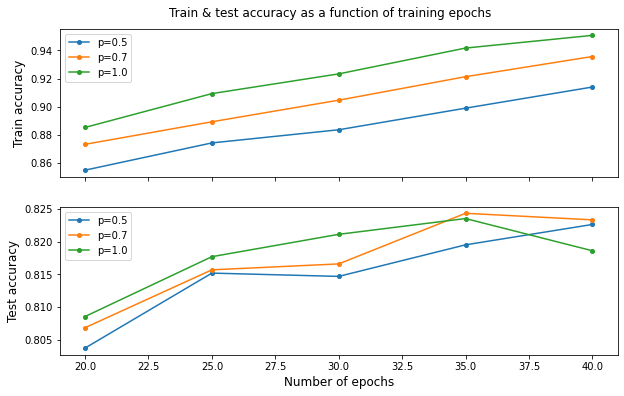

In [ ]:
x = epochs
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,6))

plt.suptitle('Train & test accuracy as a function of training epochs',x=.5,y=.93,fontsize=12)

ax[0].plot(x, p5train,'.-', markersize=8,label='p=0.5')
ax[0].plot(x, p7train,'.-', markersize=8,label='p=0.7')
ax[0].plot(x, p1train,'.-', markersize=8,label='p=1.0')
#ax[0].plot(x, [max(train_acc)] * len(x),label='Max. accuracy:'+str(round(max(train_acc),4)))
ax[1].plot(x, p5,'.-', markersize=8, label='p=0.5')
ax[1].plot(x, p7,'.-', markersize=8, label='p=0.7')
ax[1].plot(x, p1,'.-', markersize=8, label='p=1.0')
#ax[1].plot(x, [max(test_acc)] * len(x),label='Max. accuracy:'+str(round(max(test_acc),4)))

ax[1].set_xlabel('Number of epochs',fontsize=12)
ax[0].set_ylabel('Train accuracy',fontsize=12)
ax[1].set_ylabel('Test accuracy',fontsize=12)

ax[0].legend()
ax[1].legend()

plt.savefig('dropout_3000.png',bbox_inches='tight')
plt.show()

## Test accuracy vs. number of layers

In [ ]:
epochs = [5,10,15,20,25]
layer0 = []
layer1 = []
layer2 = []
for e in epochs:
  mlp = MLP(n_layers = 0,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=1)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  layer0.append(evaluate_acc(np.argmax(test_y,axis=1), results))

  mlp = MLP(n_layers = 1,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=1)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  layer1.append(evaluate_acc(np.argmax(test_y,axis=1), results))

  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=e,batch_size=200,p=1)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)
  layer2.append(evaluate_acc(np.argmax(test_y,axis=1), results))

100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


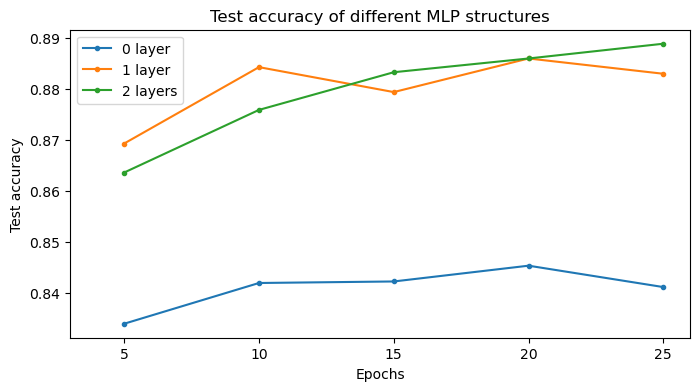

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(epochs, layer0,'.-', label='0 layer')
plt.plot(epochs, layer1,'.-', label='1 layer')
plt.plot(epochs, layer2,'.-', label='2 layers')


plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of different MLP structures')
plt.xlim(3,26)
plt.legend(fontsize=10)
plt.savefig('modelcompare.png',bbox_inches='tight')
plt.show()

## Learning rate

In [ ]:
learning_rates = [0.000005, 0.00001, 0.0001, 0.001, 0.01]
costs = []
for lr in learning_rates:
  mlp = MLP(n_layers = 2,ac_func = ReLU, ac_func_p = ReLUp,epoch=5,batch_size=200,learning_rate=lr,p=1)
  results = mlp.fit(train_x_nor,train_y).predict(test_x_nor)

  costs.append(mlp.training_loss)

100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


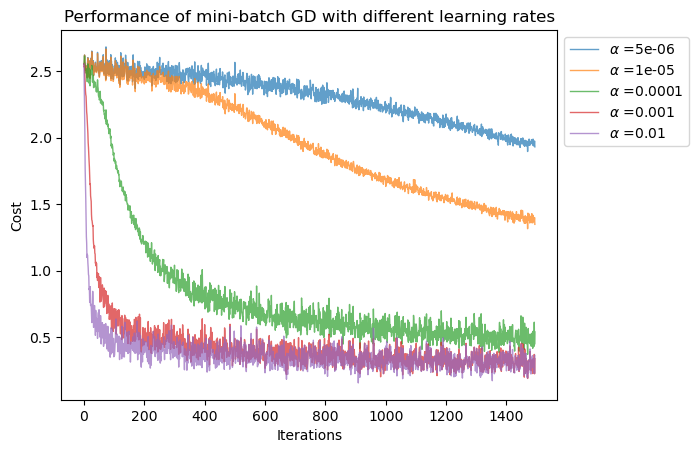

In [ ]:
x = range(len(mlp.training_loss))
plt.figure()

for i in range(len(learning_rates)):
  plt.plot(x, costs[i], label=r'$\alpha$ ='+str(learning_rates[i]), linewidth=1, alpha=.7)

plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Performance of mini-batch GD with different learning rates')
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1,1))

#plt.savefig('lrchoice.png',bbox_inches='tight')
plt.show()

## Activations

In [ ]:
relutrain_acc = []
relutest_acc = []

tantrain_acc = []
tantest_acc = []

leaktrain_acc = []
leaktest_acc = []

train_yb = np.argmax(train_y,axis=1)
test_yb = np.argmax(test_y,axis=1)

epochs = range(5,35,5)

for i in tqdm(epochs):
  mlp = MLP(ac_func = ReLU, ac_func_p = ReLUp,epoch=i,batch_size=200,p=1)
  tr = mlp.fit(train_x_nor,train_y).predict(train_x_nor)
  ts = mlp.predict(test_x_nor)

  relutrain_acc.append(evaluate_acc(train_yb, tr))
  relutest_acc.append(evaluate_acc(test_yb, ts))

  mlp = MLP(ac_func = tanh, ac_func_p = tanhp,epoch=i,batch_size=200,p=1)
  tr = mlp.fit(train_x_nor,train_y).predict(train_x_nor)
  ts = mlp.predict(test_x_nor)

  tantrain_acc.append(evaluate_acc(train_yb, tr))
  tantest_acc.append(evaluate_acc(test_yb, ts))

  mlp = MLP(ac_func = leakyReLU, ac_func_p = leakyReLUp,epoch=i,batch_size=200,p=1)
  tr = mlp.fit(train_x_nor,train_y).predict(train_x_nor)
  ts = mlp.predict(test_x_nor)

  leaktrain_acc.append(evaluate_acc(train_yb, tr))
  leaktest_acc.append(evaluate_acc(test_yb, ts))

100%|██████████| 6/6 [23:08<00:00, 231.41s/it]


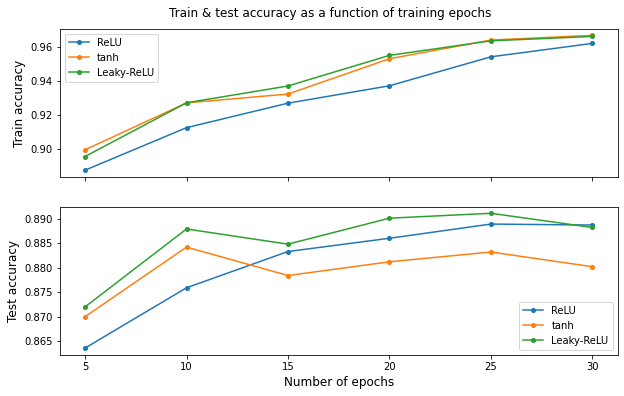

In [ ]:
x = epochs
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,6))

plt.suptitle('Train & test accuracy as a function of training epochs',x=.5,y=.93,fontsize=12)

ax[0].plot(x, relutrain_acc,'.-', markersize=8,label='ReLU')
ax[0].plot(x, tantrain_acc,'.-', markersize=8, label='tanh')
ax[0].plot(x, leaktrain_acc,'.-', markersize=8, label='Leaky-ReLU')
#ax[0].plot(x, [max(train_acc)] * len(x),label='Max. accuracy:'+str(round(max(train_acc),4)))
ax[1].plot(x, relutest_acc,'.-', markersize=8, label='ReLU')
ax[1].plot(x, tantest_acc,'.-', markersize=8, label='tanh')
ax[1].plot(x, leaktest_acc,'.-', markersize=8, label='Leaky-ReLU')
#ax[1].plot(x, [max(test_acc)] * len(x),label='Max. accuracy:'+str(round(max(test_acc),4)))

ax[1].set_xlabel('Number of epochs',fontsize=12)
ax[0].set_ylabel('Train accuracy',fontsize=12)
ax[1].set_ylabel('Test accuracy',fontsize=12)

ax[0].legend()
ax[1].legend()

plt.savefig('acfunc.png',bbox_inches='tight')
plt.show()

# CNN

### test model 1 （example of overfitting)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (6,6), strides=(2, 2), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(32, (5,5), strides=(2, 2), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), #e.g. RMSprop, Adagrad
              loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_x_2D, train_y,
                    batch_size=200,
                    epochs=10,
                    validation_split=0.1)

Epoch 1/10
270/270 [==============================] - 46s 167ms/step - loss: 0.5441 - acc: 0.8050 - val_loss: 0.3738 - val_acc: 0.8610
Epoch 2/10
270/270 [==============================] - 46s 169ms/step - loss: 0.3405 - acc: 0.8757 - val_loss: 0.3492 - val_acc: 0.8670
Epoch 3/10
270/270 [==============================] - 52s 192ms/step - loss: 0.2968 - acc: 0.8915 - val_loss: 0.2932 - val_acc: 0.8925
Epoch 4/10
270/270 [==============================] - 46s 169ms/step - loss: 0.2680 - acc: 0.9011 - val_loss: 0.2980 - val_acc: 0.8888
Epoch 5/10
270/270 [==============================] - 46s 169ms/step - loss: 0.2441 - acc: 0.9090 - val_loss: 0.2785 - val_acc: 0.8965
Epoch 6/10
270/270 [==============================] - 45s 168ms/step - loss: 0.2240 - acc: 0.9168 - val_loss: 0.2729 - val_acc: 0.9013
Epoch 7/10
270/270 [==============================] - 45s 168ms/step - loss: 0.2084 - acc: 0.9228 - val_loss: 0.2668 - val_acc: 0.9023
Epoch 8/10
270/270 [==============================] - 4

In [ ]:
evaluate_acc(np.argmax(test_y,axis=1), np.argmax(model.predict(test_x_2D),axis=1))

0.8966

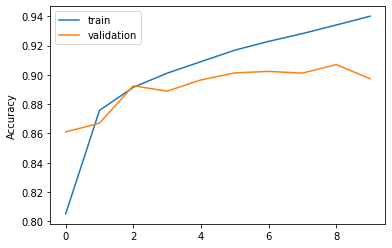

In [ ]:
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### test model 2

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(32, (5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    keras.layers.Dropout(0.5,seed=1234),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), #e.g. RMSprop, Adagrad
              loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_x_2D, train_y,
                    batch_size=200,
                    epochs=5,
                    validation_split=0.1)

Epoch 1/5
270/270 [==============================] - 247s 915ms/step - loss: 0.4594 - acc: 0.8326 - val_loss: 0.3098 - val_acc: 0.8837
Epoch 2/5
270/270 [==============================] - 246s 912ms/step - loss: 0.2954 - acc: 0.8896 - val_loss: 0.2709 - val_acc: 0.8978
Epoch 3/5
270/270 [==============================] - 247s 915ms/step - loss: 0.2521 - acc: 0.9075 - val_loss: 0.2547 - val_acc: 0.9078
Epoch 4/5
270/270 [==============================] - 248s 917ms/step - loss: 0.2238 - acc: 0.9162 - val_loss: 0.2295 - val_acc: 0.9122
Epoch 5/5
270/270 [==============================] - 250s 928ms/step - loss: 0.2007 - acc: 0.9248 - val_loss: 0.2208 - val_acc: 0.9173


In [ ]:
evaluate_acc(np.argmax(test_y,axis=1), np.argmax(model.predict(test_x_2D),axis=1))

0.9159

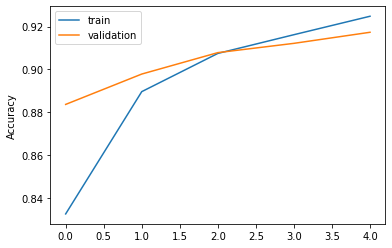

In [ ]:
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### test model 3

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), strides=(2, 2), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(32, (5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    keras.layers.Dropout(0.5,seed=1234),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5,seed=1234),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), #e.g. RMSprop, Adagrad
              loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_x_2D, train_y,
                    batch_size=200,
                    epochs=10,
                    validation_split=0.1)

Epoch 1/10
270/270 [==============================] - 66s 242ms/step - loss: 0.7097 - acc: 0.7370 - val_loss: 0.4000 - val_acc: 0.8502
Epoch 2/10
270/270 [==============================] - 65s 242ms/step - loss: 0.4454 - acc: 0.8391 - val_loss: 0.3391 - val_acc: 0.8700
Epoch 3/10
270/270 [==============================] - 66s 244ms/step - loss: 0.3899 - acc: 0.8574 - val_loss: 0.3098 - val_acc: 0.8822
Epoch 4/10
270/270 [==============================] - 66s 244ms/step - loss: 0.3586 - acc: 0.8686 - val_loss: 0.2983 - val_acc: 0.8853
Epoch 5/10
270/270 [==============================] - 66s 244ms/step - loss: 0.3381 - acc: 0.8758 - val_loss: 0.2779 - val_acc: 0.8957
Epoch 6/10
270/270 [==============================] - 66s 244ms/step - loss: 0.3213 - acc: 0.8818 - val_loss: 0.2753 - val_acc: 0.8985
Epoch 7/10
270/270 [==============================] - 66s 243ms/step - loss: 0.3101 - acc: 0.8864 - val_loss: 0.2630 - val_acc: 0.9035
Epoch 8/10
270/270 [==============================] - 6

In [ ]:
evaluate_acc(np.argmax(test_y,axis=1), np.argmax(model.predict(test_x_2D),axis=1))

0.901

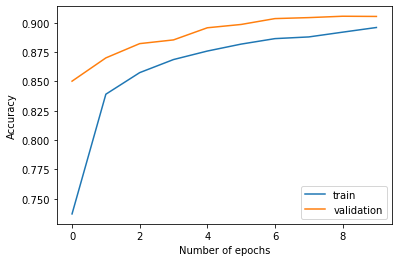

In [ ]:
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()